# Notebook 10: Recursive Forecasting (Multi-Step Ahead)

**Goal**: Implement **Recursive Forecasting** to evaluate the discrepancy between "Teacher Forcing" (using actual past values) and real-world multi-step prediction (feeding predictions back in).

**Context**: The Professor pointed out that using actual lags for 2016, 2017... (when predicting from 2015) is unrealistic. This notebook quantifies the "Error Propagation".

In [15]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error
import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('../src')))
from preprocessing import load_data

SPLIT_YEAR = 2015
TARGET = 'Value_co2_emissions_kt_by_country'
LAG_TARGET = f'{TARGET}_lag1'

# Load Best Params
with open('../data/results/best_hyperparameters.json', 'r') as f:
    best_params = json.load(f)
    
print("Loaded Best Params:", best_params)

Loaded Best Params: {'Linear Regression': {'alpha': 10.0}, 'XGBoost': {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}}


In [16]:
# Load Data
df_common = load_data('../data/processed/common_preprocessed.csv')
df_lr = load_data('../data/processed/lr_final_prep.csv')

# Align indices
common_idx = df_common.index.intersection(df_lr.index)
df_lr = df_lr.loc[common_idx]
df_lr['Year'] = df_common.loc[common_idx, 'Year']
df_lr['Entity'] = df_common.loc[common_idx, 'Entity']  # Needed for grouping

# Identify Lag Columns (we need to update these recursively)
lag_cols = [c for c in df_lr.columns if 'lag' in c]
print("Lag Features:", lag_cols)

# Only the TARGET lag needs to be recursive for this experiment
# (Assuming GDP input is exogenous/known for conditional forecasting)
target_lag_col = next((c for c in lag_cols if TARGET in c), None)
print("Target Lag Column:", target_lag_col)

Loaded data from ../data/processed/common_preprocessed.csv: (3473, 25)
Loaded data from ../data/processed/lr_final_prep.csv: (2190, 193)
Lag Features: ['Value_co2_emissions_kt_by_country_lag1', 'gdp_growth_lag1', 'Primary energy consumption per capita (kWh/person)_lag1']
Target Lag Column: Value_co2_emissions_kt_by_country_lag1


## 1. Re-Establish Cluster Labels (Static Assignment)

In [17]:
cluster_cols = ['gdp_per_capita', 'Access to electricity (% of population)', 
                'Renewable energy share in the total final energy consumption (%)', 
                'Primary energy consumption per capita (kWh/person)']

# TRAIN DATA ONLY (< 2015)
df_profile = df_common[df_common['Year'] < SPLIT_YEAR].groupby('Entity')[cluster_cols].mean().dropna()

scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_profile)

kmeans = KMeans(n_clusters=3, random_state=42)
df_profile['Cluster'] = kmeans.fit_predict(X_cluster)

# Map to main dataframe
df_lr['Cluster'] = df_lr['Entity'].map(df_profile['Cluster'])
df_lr.dropna(subset=['Cluster'], inplace=True)
df_lr['Cluster'] = df_lr['Cluster'].astype(int)

## 2. Train Models (One per Cluster)

In [18]:
models = {}
params_lr = best_params.get('Linear Regression', {})

# Prepare Train Data (All years < SPLIT_YEAR)
train_full = df_lr[df_lr['Year'] < SPLIT_YEAR]

drop_cols = [TARGET, 'Year', 'Cluster', 'Entity']
feature_cols = [c for c in df_lr.columns if c not in drop_cols]

print("Training models...")
for c in sorted(df_lr['Cluster'].unique()):
    data_c = train_full[train_full['Cluster'] == c]
    X_train = data_c[feature_cols]
    y_train = data_c[TARGET]
    
    model = Ridge(**params_lr)
    model.fit(X_train, y_train)
    models[c] = model
    print(f"Cluster {c} Model Trained.")

Training models...


Cluster 0 Model Trained.
Cluster 1 Model Trained.
Cluster 2 Model Trained.


## 3. Recursive Forecasting Loop

In [19]:
test_df = df_lr[df_lr['Year'] >= SPLIT_YEAR].copy()
test_years = sorted(test_df['Year'].unique())
entities = test_df['Entity'].unique()

# Determine if target was scaled (StandardScaler applied in notebook 2)
print("Target Mean:", test_df[TARGET].mean())
print("Target Lag Mean:", test_df[target_lag_col].mean())

# Reconstruct Scaler
# Strategy: Calculate Mean/Std of the UN-SCALED Lag Feature from common_preprocessed 
# BUT LIMITED TO THE ROWS IN df_lr (which has outliers removed)
# This mimics the StandardScaler behavior in Notebook 2 which fit on df_lr

# Unscaled Lags (aligned to clean data)
unscaled_lag = df_common.loc[df_lr.index, target_lag_col]
# Scaled Lags (from clean normalized data)
scaled_lag = df_lr[target_lag_col]

lag_mean = unscaled_lag.mean()
lag_std = unscaled_lag.std()

# Check if manual scaling matches
reconstructed = (unscaled_lag - lag_mean) / lag_std
valid_mask = ~reconstructed.isna() & ~scaled_lag.isna()
corr = np.corrcoef(reconstructed[valid_mask], scaled_lag[valid_mask])[0,1]
print(f"Reconstructed Scaler Correlation: {corr:.4f}")

def scale_value(val):
    return (val - lag_mean) / lag_std

# --- Recursive Loop ---
recursive_preds = []
teacher_forcing_preds = []
actuals = []
years = []
entities_list = []

# We must iterate year by year. 
# Modifications to df_lr (test set) must persist to the next iteration.
test_df_recursive = test_df.copy()

print("Starting Recursive Forecasting...")

for year in test_years:
    print(f"Processing Year: {year}")
    # Get data for this year
    current_year_df = test_df_recursive[test_df_recursive['Year'] == year]
    
    if current_year_df.empty: continue
        
    for idx, row in current_year_df.iterrows():
        cluster = int(row['Cluster'])
        entity = row['Entity']
        
        # Predict using current features (which contain previous year's updated lags)
        features = row[feature_cols].values.reshape(1, -1)
        pred = models[cluster].predict(features)[0]
        
        # Store Results
        recursive_preds.append(pred)
        actuals.append(row[TARGET])
        years.append(year)
        entities_list.append(entity)
        
        # Teacher Forcing Prediction (for comparison)
        # We use the original test_df which has the 'true' lags
        tf_row = test_df[(test_df['Year'] == year) & (test_df['Entity'] == entity)]
        if not tf_row.empty:
            tf_features = tf_row[feature_cols].values.reshape(1, -1)
            tf_pred = models[cluster].predict(tf_features)[0]
            teacher_forcing_preds.append(tf_pred)
        
        # UPDATE NEXT YEAR'S LAG 
        # The predicted 'pred' is for Year T. 
        # This becomes the Lag for Year T+1.
        next_year = year + 1
        if next_year <= max(test_years):
            # Find the row for this entity in next year
            mask = (test_df_recursive['Year'] == next_year) & (test_df_recursive['Entity'] == entity)
            if mask.any():
                # Scale the prediction before inserting as feature
                scaled_pred = scale_value(pred)
                test_df_recursive.loc[mask, target_lag_col] = scaled_pred

Target Mean: 22536.209948347376
Target Lag Mean: 0.037478711637161585
Reconstructed Scaler Correlation: 0.0654
Starting Recursive Forecasting...
Processing Year: 2015


/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid fe

Processing Year: 2016
Processing Year: 2017


/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid fe

Processing Year: 2018
Processing Year: 2019


/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid fe

Processing Year: 2020


/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/funalee/UIT/DS102/Global-Energy/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid fe

## 4. Comparison & Analysis

In [20]:
results_df = pd.DataFrame({
    'Entity': entities_list,
    'Year': years,
    'Actual': actuals,
    'Recursive_Pred': recursive_preds,
    'Teacher_Forcing_Pred': teacher_forcing_preds
})

# Calculate Global Metrics
r2_rec = r2_score(results_df['Actual'], results_df['Recursive_Pred'])
r2_tf = r2_score(results_df['Actual'], results_df['Teacher_Forcing_Pred'])

rmse_rec = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Recursive_Pred']))
rmse_tf = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Teacher_Forcing_Pred']))

print(f"Teacher Forcing (One-Step) R2: {r2_tf:.4f}")
print(f"Recursive Forecasting   R2: {r2_rec:.4f}")
print(f"Drop in Performance: {(r2_tf - r2_rec) / r2_tf * 100:.2f}%")

# Create Comparison Table
comparison = pd.DataFrame({
    'Method': ['One-Step (Teacher Forcing)', 'Recursive (Multi-Step)'],
    'R2 Score': [r2_tf, r2_rec],
    'RMSE': [rmse_tf, rmse_rec]
})

# Save Results
comparison.to_csv('../data/results/recursive_comparison.csv', index=False)
print(comparison)

Teacher Forcing (One-Step) R2: 0.9748
Recursive Forecasting   R2: 0.5292
Drop in Performance: 45.70%
                       Method  R2 Score          RMSE
0  One-Step (Teacher Forcing)  0.974756   5670.576210
1      Recursive (Multi-Step)  0.529248  24487.400102


Plot saved to ../reports/figures/recursive_comparison_plot.png


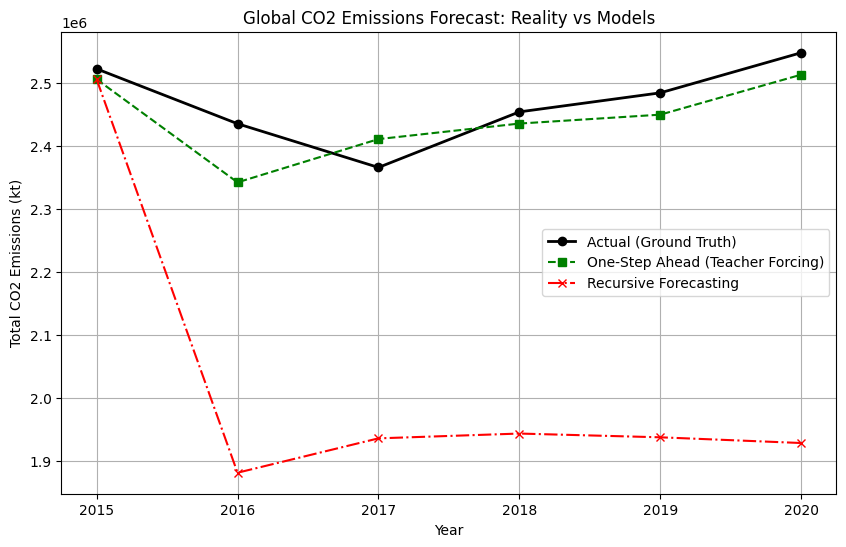

In [21]:
# Plot Global Trend Comparison (3 Lines)
# Aggregating by Year to show the global divergence
global_trends = results_df.groupby('Year')[['Actual', 'Teacher_Forcing_Pred', 'Recursive_Pred']].sum()

plt.figure(figsize=(10, 6))
plt.plot(global_trends.index, global_trends['Actual'], marker='o', label='Actual (Ground Truth)', color='black', linewidth=2)
plt.plot(global_trends.index, global_trends['Teacher_Forcing_Pred'], marker='s', linestyle='--', label='One-Step Ahead (Teacher Forcing)', color='green')
plt.plot(global_trends.index, global_trends['Recursive_Pred'], marker='x', linestyle='-.', label='Recursive Forecasting', color='red')

plt.title('Global CO2 Emissions Forecast: Reality vs Models')
plt.ylabel('Total CO2 Emissions (kt)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.savefig('../reports/figures/recursive_comparison_plot.png')
print("Plot saved to ../reports/figures/recursive_comparison_plot.png")